In [203]:
import os
from os import listdir
import pandas as pd
path = os.getcwd()
print (listdir(path))

ori_train = pd.read_csv("train.csv")
ori_test = pd.read_csv("test.csv")

train = ori_train.copy()
final_test = ori_test.copy()

whole = ori_train.append(ori_test)
print (len(train), len(test), len(whole))


['Titanic 1.ipynb', 'Titanic 2.ipynb', 'README.md', 'test.csv', '.ipynb_checkpoints', 'train.csv', '.git', 'gender_submission.csv']
891 134 1309


In [204]:
final_test = ori_test.copy()
final_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [205]:
test.isna().sum()

Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
n_FamMem       0
Family_size    0
Title          0
Age_group      0
dtype: int64

In [206]:
print (train.isna().sum())
#too many NaN for Cabin, maybe drop it later
print (train.Cabin.isna().sum()/len(train.Cabin))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
0.7710437710437711


U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

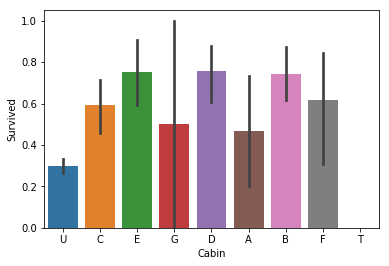

In [207]:
import seaborn as sns
train.Cabin = train.Cabin.fillna("U")
train.Cabin = train.Cabin.apply(lambda x:x[0])
sns.barplot(x = train.Cabin, y = "Survived", data = train)
train.Cabin.value_counts()


some Carbin has a higher survival rate. Online information shows B & C is mostly for first class but also large section on A,D,E used for first class as well. Too many NaN to reflect anything accurate. PClass column would do a better job at reflecting the relationship between class and survivorship.

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Age')

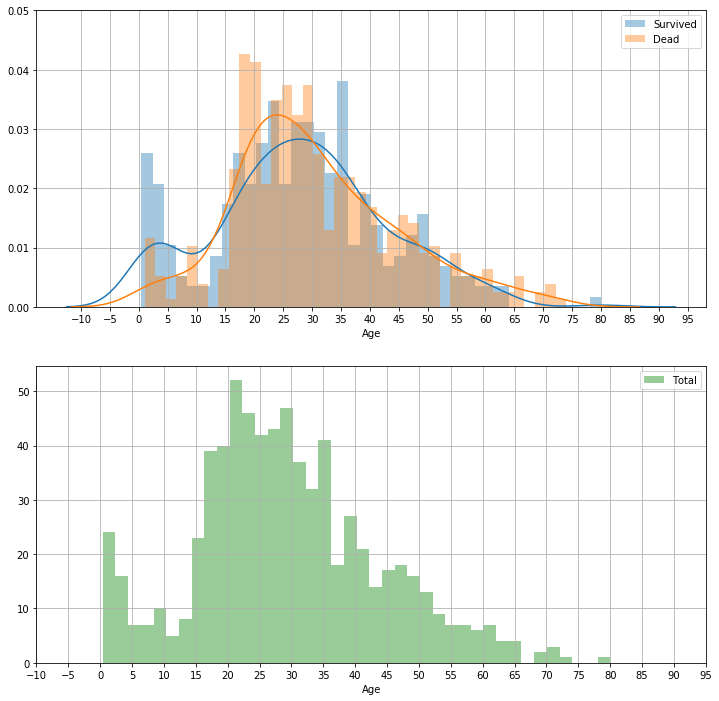

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
corr  = train[["Age", "Survived"]]
# corr = 
corr = corr.dropna()

# print (corr)
fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.distplot(corr.Age, hist = 1, label = "Total", ax = ax2, color = "g", kde = 0, bins = 40)
sns.distplot(corr.loc[corr["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax1, bins = 40)
sns.distplot(corr.loc[corr["Survived"] == 0].Age, hist = 1, label = "Dead", ax = ax1, bins = 40)
ax1.xaxis.set_ticks(range(-10, 100, 5))
ax2.xaxis.set_ticks(range(-10, 100, 5))
ax1.set_ylim(0,0.05)
ax2.legend()
ax1.legend()
ax2.grid()
ax1.grid()

ax2.set_xlabel("Age")



Age seems to have a little correlation with survival rate, especially the person being really young would drastically increase survivial rate. Therefore won't drop the Age column but will fill the age in somehow instead.

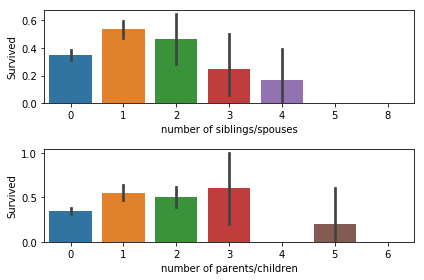

In [209]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "SibSp", y = "Survived", data = train, ax = ax1)
sns.barplot(x = "Parch", y = "Survived", data = train, ax= ax2)
ax1.set_xlabel("number of siblings/spouses")
ax2.set_xlabel("number of parents/children")
fig.tight_layout()


Text(0.5,0,'family size')

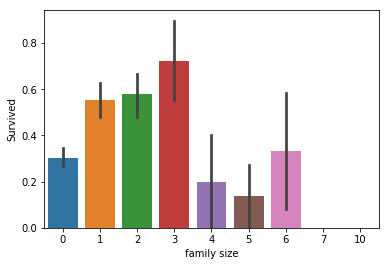

In [210]:
sns.barplot(train.SibSp + train.Parch, train.Survived)
plt.xlabel("family size")

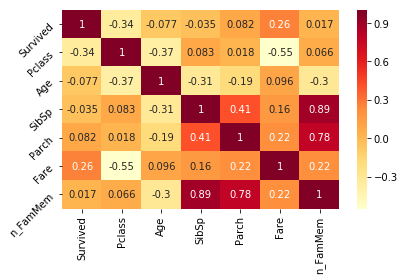

In [211]:
import numpy as np
train["n_FamMem"] = train.SibSp + train.Parch
train["Family_size"] = train["n_FamMem"].apply(lambda x: "alone" if x == 0 else "small" if x <4 else "large")

corr = train.drop(["PassengerId",], axis = 1).corr()
sns.heatmap(corr, cmap = "YlOrRd", annot = True)
plt.tight_layout()
plt.yticks(rotation = 45)

final_test["n_FamMem"] = final_test.SibSp + final_test.Parch
final_test["Family_size"] = final_test["n_FamMem"].apply(lambda x: "alone" if x == 0 else "small" if x <4 else "large")


Decided to drop Parch and SibSp because checking logisitic regression feature importance later on noticed that SibSp and Parch dont' make much difference. Also help reduce dimentionality.

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


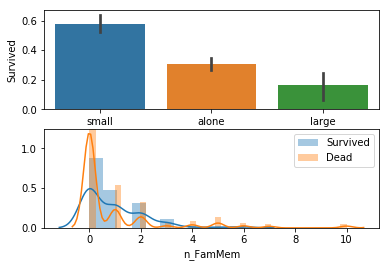

In [212]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "Family_size", y = "Survived", data = train, ax = ax1)
sns.distplot(train.loc[train["Survived"] == 1].n_FamMem, hist = 1, label = "Survived", ax = ax2)
sns.distplot(train.loc[train["Survived"] == 0].n_FamMem, hist = 1, label = "Dead", ax = ax2)

plt.legend()

In [213]:

def normalise_title(data):
    data["Title"] = data.Name.str.split(",").apply(lambda x:x[1].split(".")[0].strip())
    data.loc[data.Title.str.contains("Ms"), "Title"] = "Miss"
    data.loc[data.Title.str.contains("Mlle"), "Title"] = "Miss"
    data.loc[data.Title.str.contains("Mme"), "Title"] = "Mrs"
    #Master is generally a title given to boys at the 19th Century 、
    # (though some adult still carry that title since earlier days), keep it as kid tend to survive
    # data.loc[data.Title.str.contains("Master"), "Title"] = "Mr"
    data.loc[data.Title.str.contains("Lady"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Sir"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("the Countess"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Jonkheer"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Don"), "Title"] = "Royalty"
    data.loc[data.Title.str.contains("Capt"), "Title"] = "Military"
    data.loc[data.Title.str.contains("Major"), "Title"] = "Military"
    data.loc[data.Title.str.contains("Col"), "Title"] = "Military"
    return data
train = normalise_title(train)
final_test = normalise_title(final_test)
print (train.Title.value_counts())

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Military      5
Royalty       5
Name: Title, dtype: int64


In [214]:
%time
def special_age_replace(data):
    # replace NaN age with their spouse/siblings
    for i in range(len(data)):
        if data.at[i, "SibSp"] > 0 and data.at[i, "Parch"] == 0 \
          and pd.isna(data.at[i, "Age"]):
    #         print (pd.isna(data.at[i, "Age"]))
            #can ascertain the companions are spouse or sibling and should have similar age
    #         print (data.loc[i, "Name"])
            comp = data[data.Ticket == data.iloc[i].Ticket]
    #         print (comp)
            mean_age = comp.Age.mean()   
    #         print (mean_age)
            data.at[i, "Age"] = mean_age
    return data

train = special_age_replace(train)
final_test = special_age_replace(final_test)        

train[train.Name.str.contains("Goldenberg")] #example
        


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.53 µs


PassengerId  Survived  Pclass  \
453          454         1       1   
849          850         1       1   

                                             Name     Sex   Age  SibSp  Parch  \
453                      Goldenberg, Mr. Samuel L    male  49.0      1      0   
849  Goldenberg, Mrs. Samuel L (Edwiga Grabowska)  female  49.0      1      0   

    Ticket     Fare Cabin Embarked  n_FamMem Family_size Title  
453  17453  89.1042     C        C         1       small    Mr  
849  17453  89.1042     C        C         1       small   Mrs

In [215]:
#both are woman, same ticket
train[pd.isna(train.Embarked)]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  n_FamMem  \
61   female  38.0      0      0  113572  80.0     B      NaN         0   
829  female  62.0      0      0  113572  80.0     B      NaN         0   

    Family_size Title  
61        alone  Miss  
829       alone   Mrs

In [216]:

# print (train.groupby().count_)
train.groupby("Embarked").Fare.describe()

count       mean        std     min       25%    50%        75%  \
Embarked                                                                    
C         168.0  59.954144  83.912994  4.0125  13.69795  29.70  78.500025   
Q          77.0  13.276030  14.188047  6.7500   7.75000   7.75  15.500000   
S         644.0  27.079812  35.887993  0.0000   8.05000  13.00  27.900000   

               max  
Embarked            
C         512.3292  
Q          90.0000  
S         263.0000

Both are woman, same ticket number and same Fare price, So I am going to assume they embarked from the same place(probably know each other). Although at first sight it appears that their high fare price suggest they might have embarked from C, searching online revealed that Miss Icard is the maid of Mrs Stone and they boarded the ship at Southampton (https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html).

In [217]:
train.loc[pd.isna(train.Embarked), "Embarked"] = "S"

In [218]:
print (train.Title.value_counts())
group = train.groupby("Title")
group.mean()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Military      5
Royalty       5
Name: Title, dtype: int64


PassengerId  Survived    Pclass        Age     SibSp     Parch  \
Title                                                                      
Dr         545.857143  0.428571  1.285714  42.000000  0.571429  0.000000   
Master     414.975000  0.575000  2.625000   4.574167  2.300000  1.375000   
Military   615.200000  0.400000  1.000000  56.600000  0.200000  0.200000   
Miss       411.967568  0.702703  2.291892  21.796667  0.702703  0.540541   
Mr         454.499033  0.156673  2.410058  32.368090  0.288201  0.152805   
Mrs        452.500000  0.793651  1.992063  36.263158  0.690476  0.825397   
Rev        485.666667  0.000000  2.000000  43.166667  0.166667  0.166667   
Royalty    554.200000  0.600000  1.000000  41.600000  0.400000  0.000000   

               Fare  n_FamMem  
Title                          
Dr        49.168457  0.571429  
Master    34.703125  3.675000  
Military  38.020000  0.400000  
Miss      43.800092  1.243243  
Mr        24.441560  0.441006  
Mrs       45.330290  1.515873  
Rev       18.312500  0.333333  
Royalty   42.150000  0.400000

Make sense, Miss is generally younger than Mrs, Master is usually very young and has a larger family size (board with parents). Rev has the lowest family size.

In [219]:
#split into train test set before applying mean imputation to avoid information leakage.
split_idx = int(len(train)*0.85)
test = train.iloc[split_idx:,]
train = train.iloc[:split_idx,]

train.Age = train.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))
test.Age = test.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))
final_test.Age = final_test.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


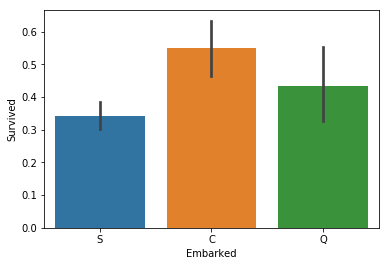

In [220]:
train.Embarked.value_counts()
sns.barplot(x = "Embarked", y = "Survived", data = train)

Embarkment place seems to make a difference so keep it.

In [221]:
print (any(pd.isna(train).any())) # double check
print (any(pd.isna(test).any()))
print (any(pd.isna(final_test).any()))

False
False
True


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


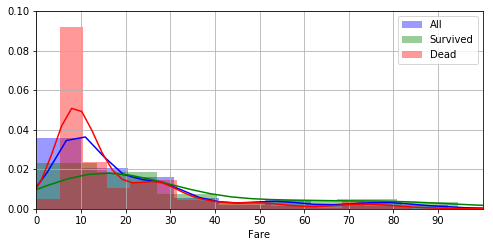

In [222]:
# sns.barplot("Pclass", "Survived", data = train)
# sns.distplot(corr.loc[corr["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax1)
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
sns.distplot(train.Fare, label = "All", ax = ax1, color = "b")
sns.distplot(train.loc[train.Survived == 1].Fare, label = "Survived", ax = ax1, color = "g")
sns.distplot(train.loc[train.Survived == 0].Fare, label = "Dead", ax = ax1, color = "r")
# ax2.set_yticks(range(0,300,50))
ax1.set_xlim(0,100)
# ax2.set_xlim(0,100)
ax1.legend()
# ax2.legend()
ax1.grid()
# ax2.grid()
ax1.set_xticks(range(0,100,10))
ax1.set_ylim(0,0.1)
# ax2.set_xticks(range(0,100,10))
plt.show()


it does seems that buying a cheap ticket has a highest chance of death

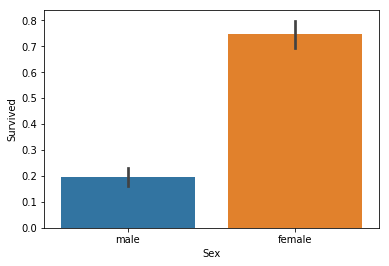

In [223]:
sns.barplot("Sex", "Survived", data = train)

In [224]:
train["Age_group"] = train.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
test["Age_group"] = test.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
final_test["Age_group"] = final_test.Age.apply(lambda x: "child" if x < 16 else "young adult" if x <33 else "adult")
train.head()

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  n_FamMem Family_size  \
0      0         A/5 21171   7.2500     U        S         1       small   
1      0          PC 17599  71.2833     C        C         1       small   
2      0  STON/O2. 3101282   7.9250     U        S         0       alone   
3      0            113803  53.1000     C        S         1       small   
4      0            373450   8.0500     U        S         0       alone   

  Title    Age_group  
0    Mr  young adult  
1   Mrs        adult  
2  Miss  young adult  
3   Mrs        adult  
4    Mr        adult

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


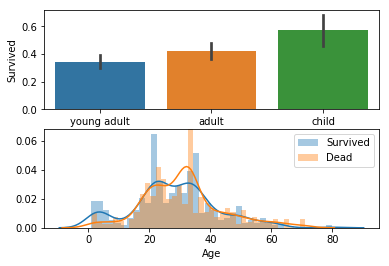

In [225]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "Age_group", y = "Survived", data = train, ax = ax1)
sns.distplot(train.loc[train["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax2, bins = 40)
sns.distplot(train.loc[train["Survived"] == 0].Age, hist = 1, label = "Dead", ax = ax2, bins = 40)
plt.legend()



In [226]:
final_test[pd.isna(final_test.Fare)]
final_test.groupby(["Pclass", "Embarked", "Age_group"]).mean()
final_test.Fare.fillna("16.977254", inplace = True)


In [227]:
train.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
train_X = train.drop(["Survived",], axis = 1)
train_y = train.Survived

test.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
test_X = test.drop(["Survived",], axis = 1)
test_y = test.Survived

final_test.drop(["Cabin", "PassengerId", "Ticket", "Name", "SibSp","Parch", ], axis = 1, inplace = True)
# test_X = test.drop(["Survived",], axis = 1) #shouldnt work

assert len(train_X.columns) == len(test_X.columns) == len(final_test.columns)
train_X.columns


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'n_FamMem', 'Family_size',
       'Title', 'Age_group'],
      dtype='object')

In [228]:
# X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "SibSp", "Parch", "Family_size", "Embarked"])

whole_X = train_X.append(test_X)
whole_X = pd.get_dummies(whole_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])

test_X = whole_X.iloc[split_idx:]
train_X = whole_X.iloc[:split_idx]

final_test_X =  pd.get_dummies(final_test, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])

# train_X = pd.get_dummies(train_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])
# test_X = pd.get_dummies(test_X, columns = ["Sex", "Embarked", "Age_group", "Family_size", "Title"])
# X.drop(["Family_size"], axis = 1, inplace = True)
# X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "SibSp", "Parch", "Embarked"])

# X.drop(["Family_size", "SibSp", "Parch"], axis = 1, inplace = True)
# X = pd.get_dummies(X, columns = ["Title", "Sex", "Age", "Embarked"])
print ("Number of features: " + str(len(train_X.columns)))

Number of features: 23


In [229]:
train_X.columns

Index(['Pclass', 'Age', 'Fare', 'n_FamMem', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Age_group_adult',
       'Age_group_child', 'Age_group_young adult', 'Family_size_alone',
       'Family_size_large', 'Family_size_small', 'Title_Dr', 'Title_Master',
       'Title_Military', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
       'Title_Royalty'],
      dtype='object')

In [230]:
# X.drop("Fare", axis = 1, inplace = True)

from sklearn import preprocessing

columns = train_X.columns
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 100)
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)




In [231]:
import warnings
def GridSearch(estimator, params):
    with warnings.catch_warnings():
#         estimator.fit(X, y)
         
        print ("original CV score:" + str(cross_val_score(estimator, train_X, train_y, cv = 3).mean()))
#         print ("original test score:" + str(estimator.fit(train_X, train_y).score(test_X, test_y)))
        warnings.simplefilter("ignore", category=UserWarning)
        warnings.simplefilter("ignore", category=DeprecationWarning)
        clf_gs = GridSearchCV(estimator, params, refit = True, cv = 3)
        clf_gs.fit(train_X, train_y)
    print ("CV score after grid search: " + str(clf_gs.best_score_))
    print ("test score after grid search: " + str(clf_gs.score(test_X, test_y)))
    return clf_gs.best_estimator_
def feat_imp(coef):
    feature_im = pd.DataFrame(data = coef, columns = ["importance"], index = columns).sort_values("importance", ascending = False)
    print (feature_im.head(), feature_im.tail())
    return feature_im    

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(C = 1, n_jobs = -1)

# print (cross_val_score(clf, X, y, cv = 5).mean())
params = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
         "solver": ["liblinear", "lbfgs"], 
         "max_iter": [100, 1000]}

new_clf = GridSearch(clf, params)
feat_im = feat_imp(new_clf.coef_[0])
print (new_clf)
print(clf)




/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


original CV score:0.8150396302570216
CV score after grid search: 0.8190224570673712
test score after grid search: 0.8507462686567164
              importance
Sex_female      0.272213
Title_Mrs       0.178419
Title_Master    0.174254
Title_Miss      0.163497
Fare            0.154694                    importance
n_FamMem            -0.111929
Family_size_large   -0.234651
Sex_male            -0.272213
Title_Mr            -0.317165
Pclass              -0.356942
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [233]:
from sklearn.svm import SVC
svc = SVC(C = 1)
# svc.fit(X, y)
# print (cross_val_score(svc, X, y, cv = 5).mean())

params = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
         "kernel": ["linear", "rbf", "poly"],}

new_svc = GridSearch(svc, params)
if new_svc.kernel == "linear":
    feat_im = feat_imp(new_svc.coef_[0])
print (new_svc)

original CV score:0.812388899345421
CV score after grid search: 0.8150594451783355
test score after grid search: 0.8507462686567164
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [234]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs = -1)
# print (cross_val_score(knn, X, y, cv = 5).mean())

params = {"leaf_size": [1, 3, 10 ,30],
         "n_neighbors": [5 ,7 , 9, 11, 13],}

new_knn = GridSearch(knn, params)
print (new_knn)

original CV score:0.8124307254742037
CV score after grid search: 0.8137384412153237
test score after grid search: 0.835820895522388
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')


In [235]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-3,hidden_layer_sizes=(100,), random_state=100,learning_rate_init = 0.01 )
# print (cross_val_score(nn, X, y, cv = 5).mean())

params = {"hidden_layer_sizes": [(10,), (100,), (50,), (50,50),],
         "activation": ["relu", "logistic"], 
          "alpha": [0.00001, 0.0001, 0.001 , 0.01, 1], 
          "learning_rate": ["constant", "invscaling", "adaptive"],
          }

new_nn = GridSearch(nn, params)
print (new_nn)

original CV score:0.8110766045548653
CV score after grid search: 0.8335535006605019
test score after grid search: 0.8208955223880597
MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=100,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [ ]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1, n_estimators = 600, learning_rate = 0.2, max_depth = 3, colsample_bytree = 0.8, colsample_bylevel = 0.5)

xgb.fit(train_X, train_y)
# print (xgb.score(val_X, val_y))

params = {"max_depth": [3,4,5,6],
         "learning_rate": [0.05, 0.1, 0.2, 0.5], 
          "n_estimators": [50, 100 ,600,],
          "subsample": [0.6, 0.8, 1.0],
          "colsample_bytree": [0.6, 0.8, 1.0],
          "colsample_bylevel": [0.6, 0.8, 1.0]
          }

new_xgb = GridSearch(xgb, params)
print (new_xgb)


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


original CV score:0.8111341154819417


In [ ]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("log", new_clf), ("mlp", new_nn), ("xgb", new_xgb), ("svc", new_svc), ("knn", new_knn)], n_jobs = -1, voting = "hard")
# vc.fit(train_X, train_y)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    print (cross_val_score(vc, train_X, train_y, cv = 3).mean())
#     print(vc.score(test_X, test_y))
    print (cross_val_score(vc, test_X, test_y, cv = 3).mean())

In [94]:
from sklearn.feature_selection import RFECV

def feat_sel(estimator):
    print (estimator)
    rfe = RFECV(estimator, step = 1, cv = 5, n_jobs = -1)
#     estimator.fit(train_X, train_y)
#     print (estimator.score(val_X, val_y))
    print (cross_val_score(estimator, train_X, train_y, cv = 3).mean())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        warnings.simplefilter("ignore", category=UserWarning)
        rfe.fit(train_X, train_y)
        print (rfe.score(test_X, test_y))
    for i in range(len(columns)):
        if rfe.support_[i] == True:
            print (columns[i])  
    return rfe
            
            
rfe_clf = feat_sel(new_clf)
rfe_xgb = feat_sel(new_xgb)
    
    

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=100,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
0.8335633770416379


JoblibRuntimeError: JoblibRuntimeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f365aea3b70, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bangbangjim/anaconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bangba.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f365aea3b70, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bangbangjim/anaconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bangba.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1426                         logger.warning('Executing %s took %.3f seconds',
   1427                                        _format_handle(handle), dt)
   1428                 finally:
   1429                     self._current_handle = None
   1430             else:
-> 1431                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1432         handle = None  # Needed to break cycles when an exception occurs.
   1433 
   1434     def _set_coroutine_wrapper(self, enabled):
   1435         try:

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 6, 9, 22, 22, 196423, tzinfo=tzutc()), 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'session': '73ac2c6af2044e188bdab364ecab4662', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'73ac2c6af2044e188bdab364ecab4662']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 6, 9, 22, 22, 196423, tzinfo=tzutc()), 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'session': '73ac2c6af2044e188bdab364ecab4662', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'73ac2c6af2044e188bdab364ecab4662'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 6, 9, 22, 22, 196423, tzinfo=tzutc()), 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'session': '73ac2c6af2044e188bdab364ecab4662', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '31f69a8526e3491684fd98dbbd9a053e', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    '
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.feature_selection import RFECV\n\ndef...sel(new_nn)\nrfe_xgb = feat_sel(new_xgb)\n    \n    ', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.FunctionDef object>, <_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-94-16ee7fa4dcea>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f360c41fa20, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f360310b5d0, file "<ipython-input-94-16ee7fa4dcea>", line 20>
        result = <ExecutionResult object at 7f360c41fa20, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f360310b5d0, file "<ipython-input-94-16ee7fa4dcea>", line 20>, result=<ExecutionResult object at 7f360c41fa20, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f360310b5d0, file "<ipython-input-94-16ee7fa4dcea>", line 20>
        self.user_global_ns = {'GridSearch': <function GridSearch>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nfrom os import listdir\nimport pandas a...i_test)\nprint (len(train), len(test), len(whole))', 'test.isna().sum()', 'print (train.isna().sum())\n#too many NaN for Cab...print (train.Cabin.isna().sum()/len(train.Cabin))', 'train.Cabin = train.Cabin.fillna("U")\ntrain.Cabi...rvived", data = train)\ntrain.Cabin.value_counts()', 'train.head()', 'import os\nfrom os import listdir\nimport pandas a...i_test)\nprint (len(train), len(test), len(whole))', 'test.isna().sum()', 'print (train.isna().sum())\n#too many NaN for Cab...print (train.Cabin.isna().sum()/len(train.Cabin))', 'train.Cabin = train.Cabin.fillna("U")\ntrain.Cabi...rvived", data = train)\ntrain.Cabin.value_counts()', 'import seaborn as sns\ntrain.Cabin = train.Cabin....rvived", data = train)\ntrain.Cabin.value_counts()', 'import matplotlib.pyplot as plt\nimport seaborn a...nd()\nax2.grid()\nax1.grid()\n\nax2.set_xlabel("Age")', 'fig = plt.figure()\nax1 = fig.add_subplot(211)\nax...("number of parents/children")\nfig.tight_layout()', 'sns.barplot(train.SibSp + train.Parch, train.Survived)\nplt.xlabel("family size")', 'import numpy as np\ntrain["n_FamMem"] = train.Sib...rue)\nplt.tight_layout()\nplt.yticks(rotation = 45)', 'fig = plt.figure()\nax1 = fig.add_subplot(211)\nax...hist = 1, label = "Dead", ax = ax2)\n\nplt.legend()', '\ndef normalise_title(data):\n    data["Title"] = ...e_title(train)\nprint (train.Title.value_counts())', 'get_ipython().run_line_magic(\'time\', \'\')\n# repla...ame.str.contains("Goldenberg")] #example\n        ', '#both are woman, same ticket\ntrain[pd.isna(train.Embarked)]', '\n# print (train.groupby().count_)\ntrain.groupby("Embarked").Fare.describe()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'Out': {2: PassengerId      0
Pclass           0
Name      ...abin          327
Embarked         0
dtype: int64, 5:    PassengerId  Survived  Pclass  \
0           ...    0            373450   8.0500     U        S  , 7: PassengerId      0
Pclass           0
Name      ...abin          327
Embarked         0
dtype: int64, 10: U    687
C     59
B     47
D     33
E     32
A  ...   13
G      4
T      1
Name: Cabin, dtype: int64, 11: Text(0.5,17.2,'Age'), 13: Text(0.5,17.2,'family size'), 14: (array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]), <a list of 7 Text yticklabel objects>), 15: <matplotlib.legend.Legend object>, 17:      PassengerId  Survived  Pclass  \
453       ...1042     C        C         1       small   Mrs  , 18:      PassengerId  Survived  Pclass              ... 
61        alone  Miss  
829       alone   Mrs  , ...}, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'VotingClassifier': <class 'sklearn.ensemble.voting_classifier.VotingClassifier'>, ...}
        self.user_ns = {'GridSearch': <function GridSearch>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nfrom os import listdir\nimport pandas a...i_test)\nprint (len(train), len(test), len(whole))', 'test.isna().sum()', 'print (train.isna().sum())\n#too many NaN for Cab...print (train.Cabin.isna().sum()/len(train.Cabin))', 'train.Cabin = train.Cabin.fillna("U")\ntrain.Cabi...rvived", data = train)\ntrain.Cabin.value_counts()', 'train.head()', 'import os\nfrom os import listdir\nimport pandas a...i_test)\nprint (len(train), len(test), len(whole))', 'test.isna().sum()', 'print (train.isna().sum())\n#too many NaN for Cab...print (train.Cabin.isna().sum()/len(train.Cabin))', 'train.Cabin = train.Cabin.fillna("U")\ntrain.Cabi...rvived", data = train)\ntrain.Cabin.value_counts()', 'import seaborn as sns\ntrain.Cabin = train.Cabin....rvived", data = train)\ntrain.Cabin.value_counts()', 'import matplotlib.pyplot as plt\nimport seaborn a...nd()\nax2.grid()\nax1.grid()\n\nax2.set_xlabel("Age")', 'fig = plt.figure()\nax1 = fig.add_subplot(211)\nax...("number of parents/children")\nfig.tight_layout()', 'sns.barplot(train.SibSp + train.Parch, train.Survived)\nplt.xlabel("family size")', 'import numpy as np\ntrain["n_FamMem"] = train.Sib...rue)\nplt.tight_layout()\nplt.yticks(rotation = 45)', 'fig = plt.figure()\nax1 = fig.add_subplot(211)\nax...hist = 1, label = "Dead", ax = ax2)\n\nplt.legend()', '\ndef normalise_title(data):\n    data["Title"] = ...e_title(train)\nprint (train.Title.value_counts())', 'get_ipython().run_line_magic(\'time\', \'\')\n# repla...ame.str.contains("Goldenberg")] #example\n        ', '#both are woman, same ticket\ntrain[pd.isna(train.Embarked)]', '\n# print (train.groupby().count_)\ntrain.groupby("Embarked").Fare.describe()', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MLPClassifier': <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>, 'Out': {2: PassengerId      0
Pclass           0
Name      ...abin          327
Embarked         0
dtype: int64, 5:    PassengerId  Survived  Pclass  \
0           ...    0            373450   8.0500     U        S  , 7: PassengerId      0
Pclass           0
Name      ...abin          327
Embarked         0
dtype: int64, 10: U    687
C     59
B     47
D     33
E     32
A  ...   13
G      4
T      1
Name: Cabin, dtype: int64, 11: Text(0.5,17.2,'Age'), 13: Text(0.5,17.2,'family size'), 14: (array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]), <a list of 7 Text yticklabel objects>), 15: <matplotlib.legend.Legend object>, 17:      PassengerId  Survived  Pclass  \
453       ...1042     C        C         1       small   Mrs  , 18:      PassengerId  Survived  Pclass              ... 
61        alone  Miss  
829       alone   Mrs  , ...}, 'RFECV': <class 'sklearn.feature_selection.rfe.RFECV'>, 'SVC': <class 'sklearn.svm.classes.SVC'>, 'VotingClassifier': <class 'sklearn.ensemble.voting_classifier.VotingClassifier'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/bangbangjim/Github/kaggle-titanic/<ipython-input-94-16ee7fa4dcea> in <module>()
     15         if rfe.support_[i] == True:
     16             print (columns[i])  
     17     return rfe
     18             
     19             
---> 20 rfe_clf = feat_sel(new_nn)
     21 rfe_xgb = feat_sel(new_xgb)
     22     
     23     

...........................................................................
/home/bangbangjim/Github/kaggle-titanic/<ipython-input-94-16ee7fa4dcea> in feat_sel(estimator=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False))
      7 #     print (estimator.score(val_X, val_y))
      8     print (cross_val_score(estimator, train_X, train_y, cv = 3).mean())
      9     with warnings.catch_warnings():
     10         warnings.simplefilter("ignore", category=DeprecationWarning)
     11         warnings.simplefilter("ignore", category=UserWarning)
---> 12         rfe.fit(train_X, train_y)
     13         print (rfe.score(test_X, test_y))
     14     for i in range(len(columns)):
     15         if rfe.support_[i] == True:
     16             print (columns[i])  

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/rfe.py in fit(self=RFECV(cv=5,
   estimator=MLPClassifier(activatio...),
   n_jobs=-1, scoring=None, step=1, verbose=0), X=array([[ 0.83948399, -0.59549684, -0.49990225, .... -0.39013716,
        -0.07288405, -0.06307757]]), y=array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,...0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0]))
    431         else:
    432             parallel, func, = Parallel(n_jobs=self.n_jobs), delayed(_rfe_single_fit)
    433 
    434         scores = parallel(
    435             func(rfe, self.estimator, X, y, train, test, scorer)
--> 436             for train, test in cv.split(X, y))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = array([[ 0.83948399, -0.59549684, -0.49990225, .... -0.39013716,
        -0.07288405, -0.06307757]])
        y = array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,...0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0])
    437 
    438         scores = np.sum(scores, axis=0)
    439         n_features_to_select = max(
    440             n_features - (np.argmax(scores) * step),

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object RFECV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
RuntimeError                                       Wed Jun  6 17:22:23 2018
PID: 23298             Python 3.6.4: /home/bangbangjim/anaconda3/bin/python
...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _rfe_single_fit>, (RFE(estimator=MLPClassifier(activation='logistic...se),
  n_features_to_select=1, step=1, verbose=0), MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), array([[ 0.83948399, -0.59549684, -0.49990225, .... -0.39013716,
        -0.07288405, -0.06307757]]), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,...0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0]), array([145, 147, 148, 149, 150, 152, 153, 154, 1..., 749,
       750, 751, 752, 753, 754, 755, 756]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    143, 144, 146, 151, 156, 161, 165, 166, 172]), <function _passthrough_scorer>), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _rfe_single_fit>
        args = (RFE(estimator=MLPClassifier(activation='logistic...se),
  n_features_to_select=1, step=1, verbose=0), MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), array([[ 0.83948399, -0.59549684, -0.49990225, .... -0.39013716,
        -0.07288405, -0.06307757]]), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,...0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0]), array([145, 147, 148, 149, 150, 152, 153, 154, 1..., 749,
       750, 751, 752, 753, 754, 755, 756]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    143, 144, 146, 151, 156, 161, 165, 166, 172]), <function _passthrough_scorer>)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/rfe.py in _rfe_single_fit(rfe=RFE(estimator=MLPClassifier(activation='logistic...se),
  n_features_to_select=1, step=1, verbose=0), estimator=MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False), X=array([[ 0.83948399, -0.59549684, -0.49990225, .... -0.39013716,
        -0.07288405, -0.06307757]]), y=array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,...0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0]), train=array([145, 147, 148, 149, 150, 152, 153, 154, 1..., 749,
       750, 751, 752, 753, 754, 755, 756]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...    143, 144, 146, 151, 156, 161, 165, 166, 172]), scorer=<function _passthrough_scorer>)
     26     Return the score for a fit across one fold.
     27     """
     28     X_train, y_train = _safe_split(estimator, X, y, train)
     29     X_test, y_test = _safe_split(estimator, X, y, test, train)
     30     return rfe._fit(
---> 31         X_train, y_train, lambda estimator, features:
        X_train = array([[-0.3572945 , -0.81982255,  0.06598086, .... -0.39013716,
        -0.07288405, -0.06307757]])
        y_train = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0])
        estimator = MLPClassifier(activation='logistic', alpha=1e-05...tion=0.1,
       verbose=False, warm_start=False)
     32         _score(estimator, X_test[:, features], y_test, scorer)).scores_
     33 
     34 
     35 class RFE(BaseEstimator, MetaEstimatorMixin, SelectorMixin):

...........................................................................
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/rfe.py in _fit(self=RFE(estimator=MLPClassifier(activation='logistic...se),
  n_features_to_select=1, step=1, verbose=0), X=array([[-0.3572945 , -0.81982255,  0.06598086, .... -0.39013716,
        -0.07288405, -0.06307757]]), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]), step_score=<function _rfe_single_fit.<locals>.<lambda>>)
    176             if hasattr(estimator, 'coef_'):
    177                 coefs = estimator.coef_
    178             else:
    179                 coefs = getattr(estimator, 'feature_importances_', None)
    180             if coefs is None:
--> 181                 raise RuntimeError('The classifier does not expose '
    182                                    '"coef_" or "feature_importances_" '
    183                                    'attributes')
    184 
    185             # Get ranks

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes
___________________________________________________________________________

In [ ]:
rfe_clf.ranking_

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
cross_val_score(bnb, X, y, cv = 3).mean()


In [ ]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("log", new_clf),("xgb", new_xgb)], n_jobs = -1, voting = "soft")
# vc.fit(train_X, train_y)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    print (cross_val_score(vc, train_X, train_y, cv = 3).mean())
#     print(vc.score(test_X, test_y))
    print (cross_val_score(vc, test_X, test_y, cv = 3).mean())

In [48]:
print (cross_val_score(new_clf, train_X, train_y, cv = 3).mean())
print (cross_val_score(new_clf, test_X, test_y, cv = 3).mean())
new_train_X = rfe_xgb.transform(train_X)
new_test_X = rfe_xgb.transform(test_X)
print (cross_val_score(new_clf, new_train_X, train_y, cv = 3).mean())
print (cross_val_score(new_clf, new_test_X, test_y, cv = 3).mean())



0.8190078842252756
0.8060606060606061
0.8229761381935295
0.8136363636363636


In [2]:
print (cross_val_score(new_nn, train_X, train_y, cv = 3).mean())
print (cross_val_score(new_nn, test_X, test_y, cv = 3).mean())
new_train_X = rfe_xgb.transform(train_X)
new_test_X = rfe_xgb.transform(test_X)
print (cross_val_score(new_nn, new_train_X, train_y, cv = 3).mean())
print (cross_val_score(new_nn, new_test_X, test_y, cv = 3).mean())


NameError: name 'cross_val_score' is not defined

In [ ]:
new_clf

In [1]:
len(new_train_X[0])

NameError: name 'new_train_X' is not defined